In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Data Sources

https://ourworldindata.org/coronavirus-source-data <br>
https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures

# Other resources
https://www.jstor.org/stable/pdf/2983678.pdf?casa_token=ndhMP8_FyQcAAAAA:VdJ0dURQTcu13ymLQFa87zyAfCi4ga9JOkNwJbL1i0VRaPhFw1hwYoOIf0lSc7lg6_b8SUNCm4_uiF3wOJdhcuHYSzjGxtYa63z--GTmZbv-Ot0tE5g <br>
https://arxiv.org/pdf/0711.0189.pdf <br>
https://www.sciencedirect.com/science/article/pii/S1201971220303179#bib0010 <br>
reason for the decrease in august? https://eacea.ec.europa.eu/national-policies/eurydice/sites/eurydice/files/school_calendar_2020_21_0.pdf

In [2]:
EU = ['Belgium', 
      'Bulgaria', 
      'Denmark',
      'Germany',
      'Estonia',
      'Finland',
      'France',
      'Greece',
      'Ireland',
      'Italy',
      'Croatia',
      'Latvia',
      'Lithuania',
      'Luxembourg',
      'Malta',
      'Netherlands',
      'Austria',
      'Poland',
      'Portugal',
      'Romania',
      'Sweden',
      'Slovakia',
      'Slovenia',
      'Spain',
      'Czechia',
      'Hungary',
      'Cyprus']

In [3]:
df = pd.read_csv('owid-covid-data.csv')
df = df[df.location.isin(EU)]

In [4]:
data = df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0)

In [5]:
data = np.sqrt(data).diff().dropna()

# Study of Network Connectedness

In [6]:
import networkx as nx

In [7]:
def average_clustering(dat, edge_thresh=0.5):
    W = ((dat.corr()-np.eye(len(dat.corr())))>edge_thresh).fillna(0)
    d = W.sum(axis=1)
    W_filtered = W[d>0][(d[d>0].index.tolist())]
    G = nx.from_numpy_array(W_filtered.to_numpy())
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))

In [8]:
N = len(data)
window_size = 30

In [9]:
start_date, clustering = [], []
for start in range(0, N-window_size):
    dat = data.iloc[start:start+window_size]
    start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
    clustering.append(average_clustering(dat))

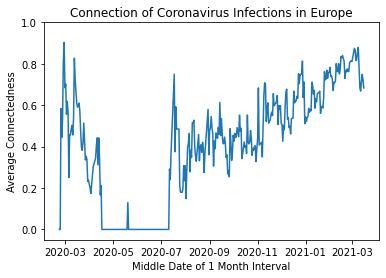

In [10]:
plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering)
plt.xlabel('Middle Date of 1 Month Interval')
plt.ylabel('Average Connectedness')
plt.title('Connection of Coronavirus Infections in Europe');
plt.ylim((-0.05,1))

clustering_unshrunk = clustering

In [11]:
import covariance_DRO

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def average_clustering_shrunk(dat, edge_thresh=0.5, method='Fisher-Rao', radius=1e-2):
    cov = dat.cov()
    cov_filtered = cov[cov.sum(axis=1)>0][(cov.sum(axis=1)[cov.sum(axis=1)>0].index.tolist())]
    cov_shrunk = np.real(covariance_DRO.estimate_cov(cov_filtered.to_numpy(), radius, method))
    if np.any(np.isnan(correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk)))):
        return np.nan
    W = correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk))>edge_thresh
    G = nx.from_numpy_array(W)
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))

In [12]:
def generate_plot(method='Fisher-Rao', radius=0.3, edge_thresh=0.5):
    start_date, clustering = [], []
    for start in range(0, N-window_size):
        dat = data.iloc[start:start+window_size]
        start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
        clustering.append(average_clustering_shrunk(dat, radius=radius, method=method))
    plt.figure()
    plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering, label=method)
    plt.xlabel('End Date of 1 Month Interval')
    plt.ylabel('Average Connectedness')
    plt.title('Connection of Coronavirus Infections in Europe');
    plt.ylim((-0.05,1))

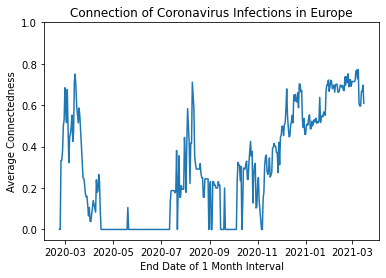

In [13]:
generate_plot(method='Fisher-Rao', radius=0.3)

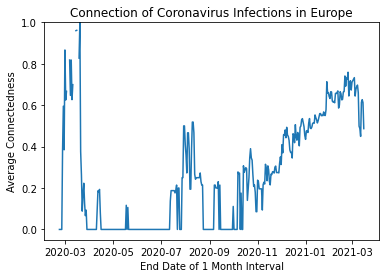

In [14]:
generate_plot(method='KLdirect', radius=0.2)

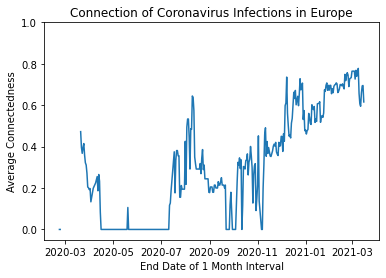

In [15]:
generate_plot(method='Wasserstein', radius=0.1)

In [16]:
def linearMethod(emp_cov, epsilon):
    mu = np.trace(emp_cov) / emp_cov.shape[0]
    cov = (1.0 - epsilon) * emp_cov
    cov.flat[:: emp_cov.shape[0] + 1] += epsilon * mu
    return cov

def linearMethodDiagonal(emp_cov, epsilon):
    mu = np.diag(np.diag(emp_cov))
    cov = (1.0 - epsilon) * emp_cov + mu * epsilon
    return cov

def average_clustering_shrunk_linear(dat, edge_thresh=0.5, epsilon=0.1, diagonal=True):
    cov = dat.cov()
    cov_filtered = cov[cov.sum(axis=1)>0][(cov.sum(axis=1)[cov.sum(axis=1)>0].index.tolist())]
    if diagonal:
        cov_shrunk = linearMethodDiagonal(cov_filtered.to_numpy(), epsilon)
    else:
        cov_shrunk = linearMethod(cov_filtered.to_numpy(), epsilon)
    if np.any(np.isnan(correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk)))):
        return np.nan
    W = correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk))>edge_thresh
    G = nx.from_numpy_array(W)
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))


In [17]:
def generate_plot_linear(diagonal=True, epsilon=0.3, edge_thresh=0.5):
    start_date, clustering = [], []
    for start in range(0, N-window_size):
        dat = data.iloc[start:start+window_size]
        start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
        clustering.append(average_clustering_shrunk_linear(dat, epsilon=epsilon, diagonal=diagonal))
    plt.figure()
    plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering)
    plt.xlabel('End Date of 1 Month Interval')
    plt.ylabel('Average Connectedness')
    plt.title('Connection of Coronavirus Infections in Europe');
    plt.ylim((-0.05,1))

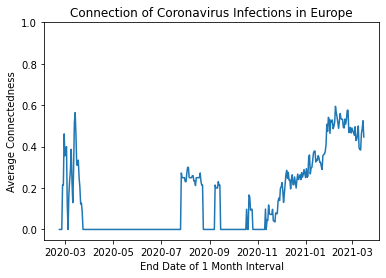

In [18]:
generate_plot_linear(diagonal=True, epsilon=0.3, edge_thresh=0.5)

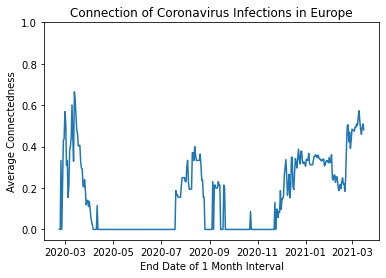

In [19]:
generate_plot_linear(diagonal=False, epsilon=0.05, edge_thresh=0.5)

In [20]:
# load measures and filter for europe
europe = list(df[df.continent=='Europe'].location.unique())
measures = pd.read_csv('COVID 19 Containment measures data.csv')
measures = measures[measures.Country.isin(europe)]
potential_measures = measures[(measures['Keywords'].str.contains('travel ban') | measures['Description of measure implemented'].str.contains('border'))]
measure_dates = [datetime.strptime(date, '%b %d, %Y') for date in list(potential_measures['Date Start'])]
df_world = pd.read_csv('owid-covid-data.csv')
europe = df_world.loc[df_world.location.isin(EU)][['date', 'new_cases_smoothed', 'location']]\
                .dropna()\
                .groupby('date')\
                .sum('new_cases_smoothed')

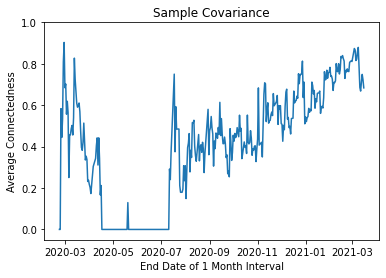

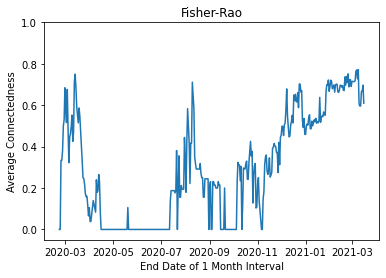

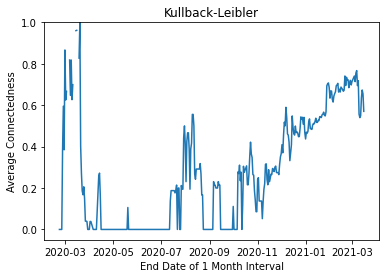

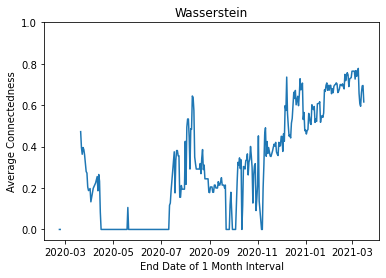

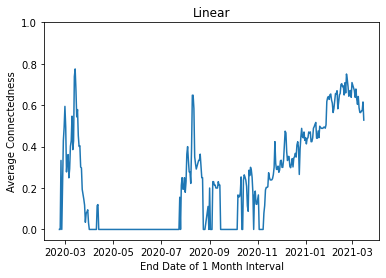

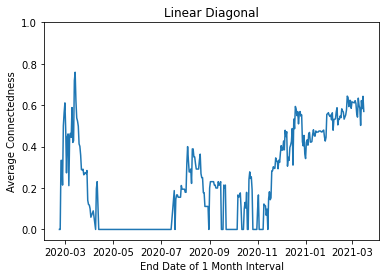

In [21]:
name = 'myplots/covid_normal_{}.pdf'

plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering_unshrunk)
plt.xlabel('End Date of 1 Month Interval')
plt.ylabel('Average Connectedness')
plt.title('Sample Covariance');
plt.ylim((-0.05,1))
plt.savefig(name.format('sample'))

generate_plot(method='Fisher-Rao', radius=0.3)
plt.title('Fisher-Rao');
plt.savefig(name.format('FR'))

generate_plot(method='KLdirect', radius=0.1)
plt.title('Kullback-Leibler');
plt.savefig(name.format('KL'))


generate_plot(method='Wasserstein', radius=0.2)
plt.title('Wasserstein');
plt.savefig(name.format('WS'))


generate_plot_linear(diagonal=True, epsilon=0.15, edge_thresh=0.5)
plt.title('Linear');
plt.savefig(name.format('linear'))


generate_plot_linear(diagonal=False, epsilon=0.02, edge_thresh=0.5)
plt.title('Linear Diagonal');
plt.savefig(name.format('linear_diag'))

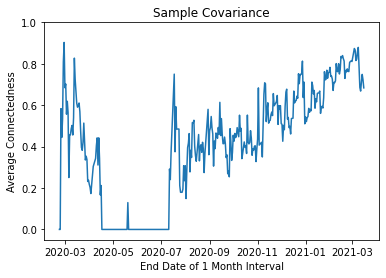

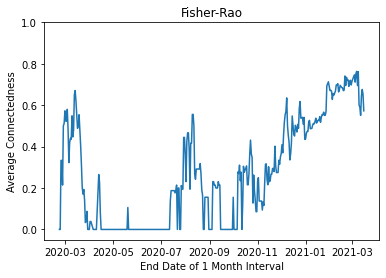

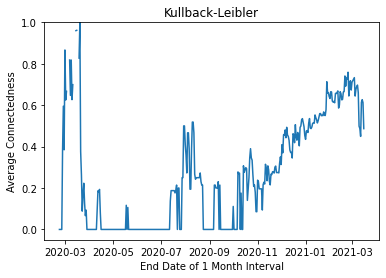

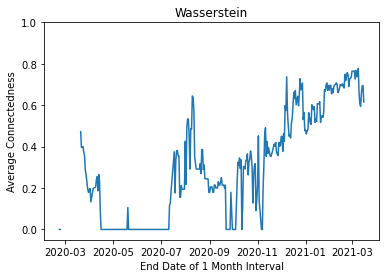

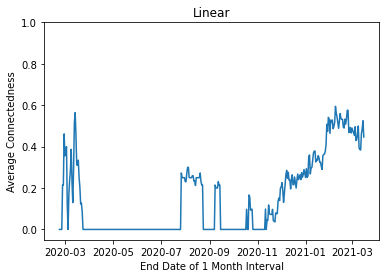

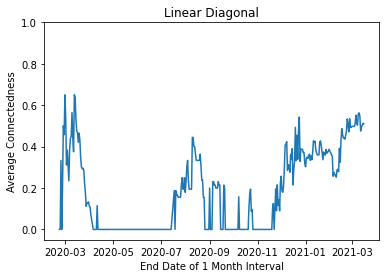

In [22]:
name = 'myplots/covid_x2_{}.pdf'

plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering_unshrunk)
plt.xlabel('End Date of 1 Month Interval')
plt.ylabel('Average Connectedness')
plt.title('Sample Covariance');
plt.ylim((-0.05,1))
plt.savefig(name.format('sample'))

generate_plot(method='Fisher-Rao', radius=0.6)
plt.title('Fisher-Rao');
plt.savefig(name.format('FR'))

generate_plot(method='KLdirect', radius=0.2)
plt.title('Kullback-Leibler');
plt.savefig(name.format('KL'))


generate_plot(method='Wasserstein', radius=0.4)
plt.title('Wasserstein');
plt.savefig(name.format('WS'))


generate_plot_linear(diagonal=True, epsilon=0.3, edge_thresh=0.5)
plt.title('Linear');
plt.savefig(name.format('linear'))


generate_plot_linear(diagonal=False, epsilon=0.04, edge_thresh=0.5)
plt.title('Linear Diagonal');
plt.savefig(name.format('linear_diag'))

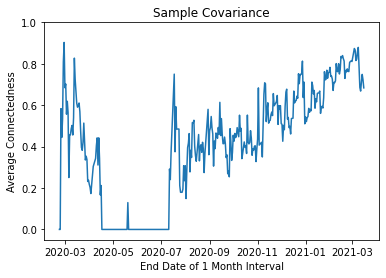

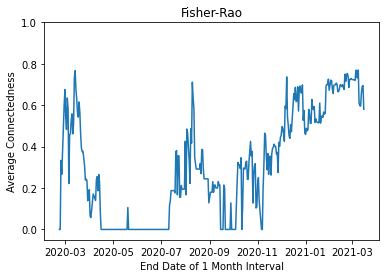

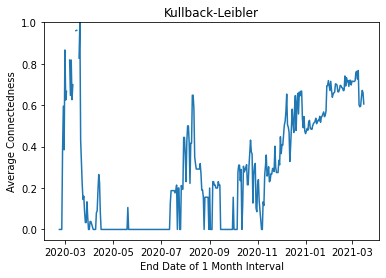

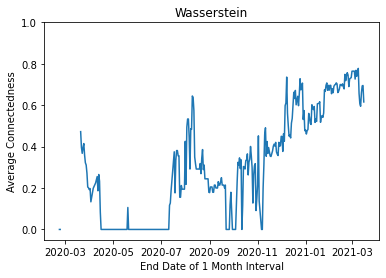

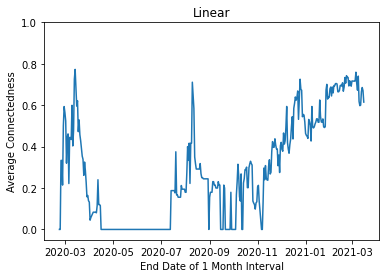

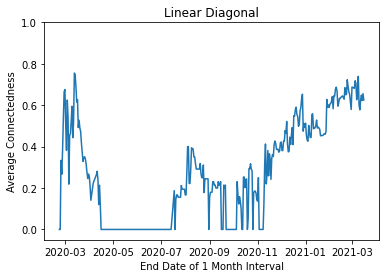

In [23]:
name = 'myplots/covid_x05_{}.pdf'

plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering_unshrunk)
plt.xlabel('End Date of 1 Month Interval')
plt.ylabel('Average Connectedness')
plt.title('Sample Covariance');
plt.ylim((-0.05,1))
plt.savefig(name.format('sample'))

generate_plot(method='Fisher-Rao', radius=0.15)
plt.title('Fisher-Rao');
plt.savefig(name.format('FR'))

generate_plot(method='KLdirect', radius=0.05)
plt.title('Kullback-Leibler');
plt.savefig(name.format('KL'))


generate_plot(method='Wasserstein', radius=0.1)
plt.title('Wasserstein');
plt.savefig(name.format('WS'))


generate_plot_linear(diagonal=True, epsilon=0.075, edge_thresh=0.5)
plt.title('Linear');
plt.savefig(name.format('linear'))


generate_plot_linear(diagonal=False, epsilon=0.01, edge_thresh=0.5)
plt.title('Linear Diagonal');
plt.savefig(name.format('linear_diag'))